# 1. GAIN trainining using Raytune
* [Raytune](https://ray.io/)
* [Raytune documentation](https://docs.ray.io/en/latest/tune/index.html)
* [Raytune PyTorch turorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)
## 1.1. Import all needed packages

In [1]:
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from fireman_imputation.GAIN import GAIN_main
from fireman_imputation.GAIN import GAINtune_main
from fireman_imputation.GAIN import GAIN_netG_forward
from fireman_imputation.src import utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

## 1.2. Main

### 1.2.1. Load Data

In [2]:
# load and scale the data
data_orig = pd.read_csv('data/spam.csv',index_col=False)
data = data_orig.values

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data_scaled = scaler.transform(data)

# create missing data mask
data_scaled_missing, mask = utils.MCARgen(data_scaled, 0.2)

# divide the data to train/test
# by default shuffles data, if pandas is passed the index shows shuffle result
data_train, data_test, mask_train, mask_test = train_test_split(data_scaled, mask, train_size=0.9)

### 1.2.2. Define hyperparameter search space

In [3]:
raytune_config = {
    'learning_rate': tune.choice([0.001,0.0001]),
    'batch_size': tune.choice([32,16]),
    'hint_rate': tune.choice([0.9,0.8]),
    'alpha': tune.grid_search([100,1000]),
    'epochs': tune.grid_search([10,100,1000]),
    }

### 1.2.3. Define scheduler'n'Reporter and run the Raytune task

In [6]:
scheduler = ASHAScheduler(
    metric="rmse",
    mode="min",
    max_t=5000,
    grace_period=1,
    reduction_factor=2)

reporter = JupyterNotebookReporter(
    overwrite= True,
    print_intermediate_tables=True, 
    parameter_columns=['learning_rate', 'batch_size', 'hint_rate', 'alpha', 'epochs'],
    metric_columns=['rmse', 'lossG', 'lossD', 'lossMSE', 'training_iteration'],
    metric='rmse')

analysis = tune.run(
    tune.with_parameters(GAIN_main,data_train=data_train, mask_train=mask_train,
                            data_test=data_test, mask_test=mask_test, raytune=True),
    name='GAIN',
    verbose=1,
    scheduler=scheduler,
    progress_reporter=reporter,
    config=raytune_config)

Trial name,status,loc,learning_rate,batch_size,hint_rate,alpha,epochs,rmse,lossG,lossD,lossMSE,training_iteration
_inner_432d2_00000,TERMINATED,,0.0001,16,0.8,100,10,0.0279125,523.969,327.089,1.49597,8
_inner_432d2_00001,TERMINATED,,0.0001,32,0.8,1000,10,0.0234457,2532.2,332.427,2.06697,10
_inner_432d2_00002,TERMINATED,,0.001,16,0.9,100,100,0.0513168,548.281,209.188,3.61122,4
_inner_432d2_00003,TERMINATED,,0.0001,32,0.8,1000,100,0.157808,80168.8,443.539,80.014,1
_inner_432d2_00004,TERMINATED,,0.0001,32,0.9,100,1000,0.163682,8232,481.487,80.9169,1
_inner_432d2_00005,TERMINATED,,0.001,32,0.9,1000,1000,0.125654,108.653,97.2487,0.0661177,1000


2021-01-17 23:27:57,169	INFO tune.py:448 -- Total run time: 423.55 seconds (423.47 seconds for the tuning loop).


### 1.2.4. Same as previous section but with predefined procedure that outputs best Generator model

In [4]:
best_trained_netG = GAINtune_main(raytune_config, data_train, mask_train, data_test, mask_test)

2021-01-17 23:13:41,422	INFO tune.py:448 -- Total run time: 43.37 seconds (41.78 seconds for the tuning loop).


Best trial config: {'learning_rate': 0.0001, 'batch_size': 32, 'hint_rate': 0.8, 'alpha': 100, 'epochs': 10}
Best trial RMSE: 0.028055148263301834
Best trial lossG: 542.092041015625


## 1.3. Visualize the results

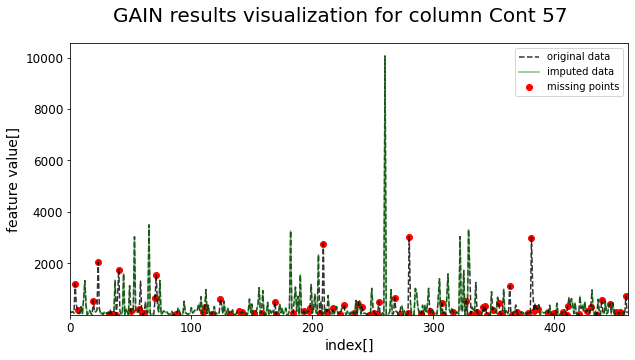

In [5]:
# impute test data
# use data_test as a "real-world" data with missing values
netG = best_trained_netG
data_test_missing = data_test.copy()
data_test_missing[mask_test==0] = np.nan
data_test_imputed = GAIN_netG_forward(netG, data_test_missing)

# rescale the imputed and test data
data_test_rescaled = scaler.inverse_transform(data_test)
data_test_imputed_rescaled = scaler.inverse_transform(data_test_imputed)

# create pandas for easier visualization
data_test_pd = pd.DataFrame(data_test_rescaled, columns=data_orig.columns)
data_test_imputed_pd = pd.DataFrame(data_test_imputed_rescaled, columns=data_orig.columns)

# define which column we want to plot and plot the plots :)
column = 'Cont 57'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('GAIN results visualization for column ' + column, size=20)

data_test_pd[column].plot(ax=ax, style='--', alpha=0.8, color='black', label='original data')
data_test_imputed_pd[column].plot(ax=ax, alpha=0.5, color='green', label='imputed data')

col_int = data_test_pd.columns.get_loc(column)
x = np.where(np.isnan(data_test_missing[:,col_int]))[0]
y = data_test_pd.iloc[x,col_int]
ax.scatter(x, y, color='red', label='missing points')
ax.set_xlim([0,len(data_test_imputed_pd)])
ax.set_ylim([data_test_imputed_pd[column].min()*0.95,data_test_imputed_pd[column].max()*1.05])
ax.tick_params(labelsize=12)
ax.set_xlabel('index[]',size=14)
ax.set_ylabel('feature value[]',size=14)

ax.legend();